In [1]:
#loading packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings 
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder


In [2]:
na_values = ["unknown"]

df = pd.read_csv('base_train.csv',
                 na_values=na_values,
                 sep=',')

In [3]:
print(f"Cantidad de filas : {df.shape[0]}")
print(f"Cantidad de columnas : {df.shape[1]}")

Cantidad de filas : 31478
Cantidad de columnas : 21


In [4]:
def plot_dist(val):
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

    # assigning a graph to each ax
    sns.boxplot(x =val, ax=ax_box)
    sns.distplot(val, ax=ax_hist)
    plt.show()
    
    


In [5]:
((df.isnull().sum() / len(df))*100).sort_values(ascending = False).to_frame()

,0
INCUMPLIMIENTO,20.859013
EDUCACION,4.177521
VIVIENDA,2.344495
PRESTAMO,2.344495
TRABAJO,0.806913
ESTADO_CIVIL,0.196963
ID,0.000000
TASA_VAR_EMP,0.000000
MONTO_TRANSAC,0.000000
MONTO_DEUDA,0.000000


- tendremos que tratar con los missings de unas pocas variables

#### EDAD

- tenemos valores outliers en la variable edad, valore mayores a 65 y menores a 21. Por el momento se desconoce el origen de esto ya que puede ser por error humano, casos muy atipicos o mal llenado de informacion del cliente. En esta situacion al ser pocos los valores con errores se optará por eliminar estas observaciones con el fin de no alterar la distribución con inputacion del promedio o mediana.

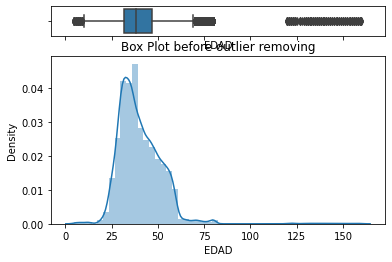

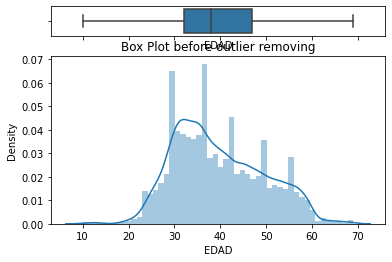

In [6]:
for i in ['EDAD']:
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

# assigning a graph to each ax
    sns.boxplot(x =df[i], ax=ax_box)
    sns.distplot(df[i], ax=ax_hist)
    plt.title("Box Plot before outlier removing")
    plt.show()
    def drop_outliers(df, field_name):
        iqr = 1.5 * (np.percentile(df[field_name], 75) - np.percentile(df[field_name], 25))
        df.drop(df[df[field_name] > (iqr + np.percentile(df[field_name], 75))].index, inplace=True)
        df.drop(df[df[field_name] < (np.percentile(df[field_name], 25) - iqr)].index, inplace=True)
    drop_outliers(df, i)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

# assigning a graph to each ax
    sns.boxplot(x =df[i], ax=ax_box)
    sns.distplot(df[i], ax=ax_hist)
    plt.title("Box Plot before outlier removing")
    plt.show()

#### trabajo

In [7]:
#imputamos con la moda ya que son pocos missings 
# Imputamos la variable TRABAJO con la moda
df['TRABAJO'].fillna(df['TRABAJO'].mode()[0], inplace=True)
print("Valores perdidos en TRABAJO: " + 
      str(df['TRABAJO'].isnull().sum()))

Valores perdidos en TRABAJO: 0


- Ya que no hay un orden distinguible para cada trabajo, dividiremos por ingresos o no ingresos.

In [8]:
df.TRABAJO.value_counts().to_dict()

{'admin.': 8145,
 'blue-collar': 7059,
 'technician': 5121,
 'services': 2998,
 'management': 2216,
 'self-employed': 1099,
 'entrepreneur': 1096,
 'retired': 994,
 'housemaid': 791,
 'unemployed': 764,
 'student': 632}

In [9]:
#1 para los trabajos que no generan ingresos
def clas_work(x):
    if x  in ['student','unemployed','retired']:
        return 0
    else:
        return 1

In [10]:
df['TRABAJO'] = df.TRABAJO.apply(clas_work)

In [11]:
df.groupby('TRABAJO').ACEPTACION.count().sort_values(ascending=False)

TRABAJO
1    28525
0     2390
Name: ACEPTACION, dtype: int64

In [12]:
df['TRABAJO'] = df.groupby('TRABAJO')['ID'].transform('count').astype('int')

In [13]:
df.groupby('TRABAJO').ACEPTACION.mean().sort_values(ascending=False)

TRABAJO
2390     0.203347
28525    0.099702
Name: ACEPTACION, dtype: float64

In [14]:
df.groupby('TRABAJO').INGRESO .median().sort_values(ascending=False)

TRABAJO
2390     1943.807985
28525    1484.228462
Name: INGRESO, dtype: float64

In [15]:
df['TRABAJO'] = df.groupby('TRABAJO')['ID'].transform('count').astype('int')

#### ESTADO CIVIL

In [16]:
# Imputamos la variable ESTADO_CIVIL con la moda
df['ESTADO_CIVIL'].fillna(df['ESTADO_CIVIL'].mode()[0], inplace=True)
print("Valores perdidos en ESTADO_CIVIL: " + 
      str(df['ESTADO_CIVIL'].isnull().sum()))

Valores perdidos en ESTADO_CIVIL: 0


In [17]:
df = df.replace({'ESTADO_CIVIL':{' married':'married', 'marrid': 'married','singgle ':'single'
                            ,'single ': 'single', 'divorced ':'divorced','d_ivorced': 'divorced'}})

In [18]:
df.ESTADO_CIVIL.value_counts()

married     18802
single       8730
divorced     3383
Name: ESTADO_CIVIL, dtype: int64

In [19]:
df.groupby('ESTADO_CIVIL').ACEPTACION.mean()

ESTADO_CIVIL
divorced    0.091339
married     0.096160
single      0.138946
Name: ACEPTACION, dtype: float64

In [20]:
pd.get_dummies(df['ESTADO_CIVIL'], drop_first=True)


,married,single
0,0,1
1,0,1
2,1,0
3,0,0
4,1,0
...,...,...
31473,0,1
31474,0,0
31475,0,1
31476,1,0


In [21]:
df = pd.concat([df.drop(columns='ESTADO_CIVIL', axis=1),pd.get_dummies(df['ESTADO_CIVIL'], drop_first=True)], axis=1)

#### EDUCACION

In [22]:
df['EDUCACION'].isnull().sum()

1272

In [23]:
# Imputamos la variable EDUCACION con la moda
df['EDUCACION'].fillna(df['EDUCACION'].mode()[0], inplace=True)
print("Valores perdidos en EDUCACION: " + 
      str(df['EDUCACION'].isnull().sum()))

Valores perdidos en EDUCACION: 0


In [24]:
df['EDUCACION'] = df.EDUCACION.replace({'illiterate': 'basic','basic.6y': 'basic','basic.4y':'basic','basic.9y':'basic','unknown':np.nan})



In [25]:
df.EDUCACION.value_counts().to_dict()

{'university.degree': 10424,
 'basic': 9355,
 'high.school': 7159,
 'professional.course': 3977}

In [26]:
df['EDUCACION'] = df['EDUCACION'].replace({'basic':1,'high.school': 2 ,'professional.course':3, 'university.degree':4 })

---

#### INCUMPLIMIENTO 

In [27]:
df.INCUMPLIMIENTO.isna().sum()

6498

In [28]:
df.INCUMPLIMIENTO.value_counts()

no     24414
yes        3
Name: INCUMPLIMIENTO, dtype: int64

<AxesSubplot:xlabel='ACEPTACION', ylabel='count'>

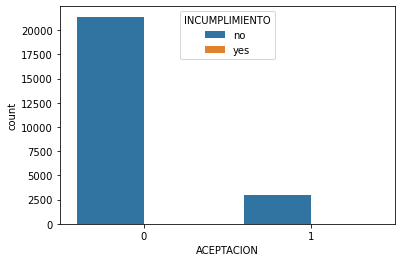

In [29]:
sns.countplot(x=df.ACEPTACION, hue=df.INCUMPLIMIENTO)

In [30]:
# Eliminamos esta variable debido a que no generara impacto en uno de sus segmentos por tener información insuficiente
df.drop(['INCUMPLIMIENTO'], axis=1, inplace=True)

#### VIVIENDA 

In [31]:
df.VIVIENDA.isna().sum()

727

In [32]:

df.VIVIENDA.value_counts()

yes    16199
no     13989
Name: VIVIENDA, dtype: int64

In [33]:
# Imputamos la variable VIVIENDA con la moda
df['VIVIENDA'].fillna(df['VIVIENDA'].mode()[0], inplace=True)
print("Valores perdidos en VIVIENDA: " + 
      str(df['VIVIENDA'].isnull().sum()))

Valores perdidos en VIVIENDA: 0


In [88]:
df['VIVIENDA'] = df['VIVIENDA'].replace({'yes':1,'no':0})

<AxesSubplot:xlabel='ACEPTACION', ylabel='count'>

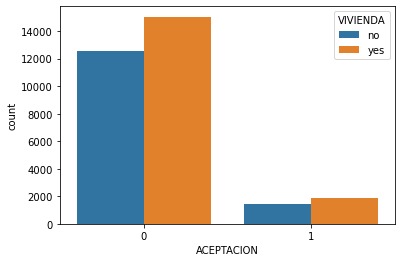

In [34]:
sns.countplot(x=df.ACEPTACION, hue=df.VIVIENDA)

#### PRESTAMO 

In [35]:
df.PRESTAMO.value_counts()

no     25533
yes     4655
Name: PRESTAMO, dtype: int64

In [36]:
df.PRESTAMO.isna().sum()

727

In [37]:
# Imputamos la variable PRESTAMO con la moda
df['PRESTAMO'].fillna(df['PRESTAMO'].mode()[0], inplace=True)
print("Valores perdidos en PRESTAMO: " + 
      str(df['PRESTAMO'].isnull().sum()))

Valores perdidos en PRESTAMO: 0


In [89]:
df['PRESTAMO'] = df['PRESTAMO'].replace({'yes':1,'no':0})

<AxesSubplot:xlabel='ACEPTACION', ylabel='count'>

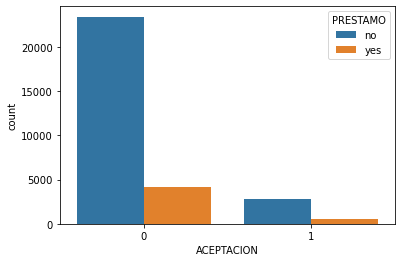

In [38]:
sns.countplot(x=df.ACEPTACION, hue=df.PRESTAMO)

#### TIPO_CONTACTO 

In [39]:
df.TIPO_CONTACTO.value_counts().to_dict()

{'cellular': 19511, 'telephone': 11404}

In [40]:
df['TIPO_CONTACTO'] = df.TIPO_CONTACTO.replace({'cellular':1,'telephone':0})

#### MES 

In [41]:
df['MES'] = df['MES'].replace(
    {'may': 5,
 'sep': 9,
 'oct': 10,
 'jun': 6,
 'nov': 11,
 'apr': 4,
 'aug': 8,
 'jul': 7,
 'mar': 3,
 'dec': 12}    
)

#### CAMPANA 

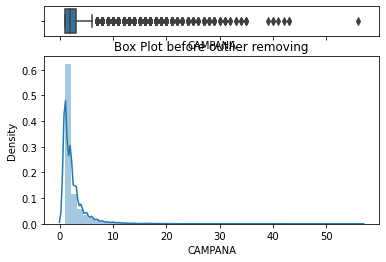

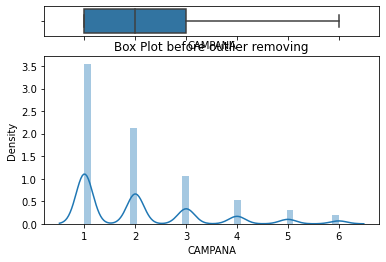

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
for i in ['CAMPANA']:
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

# assigning a graph to each ax
    sns.boxplot(x =df[i], ax=ax_box)
    sns.distplot(df[i], ax=ax_hist)
    plt.title("Box Plot before outlier removing")
    plt.show()
    def drop_outliers(df, field_name):
        iqr = 1.5 * (np.percentile(df[field_name], 75) - np.percentile(df[field_name], 25))
        df.drop(df[df[field_name] > (iqr + np.percentile(df[field_name], 75))].index, inplace=True)
        df.drop(df[df[field_name] < (np.percentile(df[field_name], 25) - iqr)].index, inplace=True)
    drop_outliers(df, i)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

# assigning a graph to each ax
    sns.boxplot(x =df[i], ax=ax_box)
    sns.distplot(df[i], ax=ax_hist)
    plt.title("Box Plot before outlier removing")
    plt.show()

#### NRO_DIAS_CONTACTO 

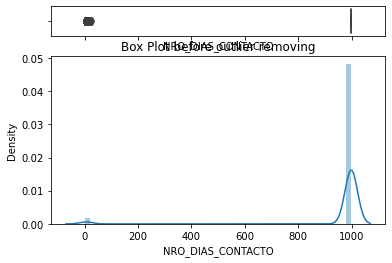

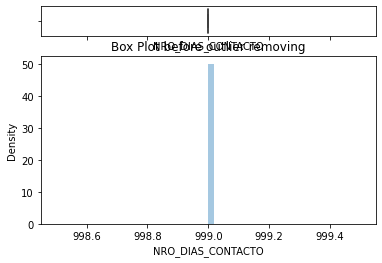

In [60]:
for i in ['NRO_DIAS_CONTACTO']:
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

# assigning a graph to each ax
    sns.boxplot(x =df[i], ax=ax_box)
    sns.distplot(df[i], ax=ax_hist)
    plt.title("Box Plot before outlier removing")
    plt.show()
    def drop_outliers(df, field_name):
        iqr = 1.5 * (np.percentile(df[field_name], 75) - np.percentile(df[field_name], 25))
        df.drop(df[df[field_name] > (iqr + np.percentile(df[field_name], 75))].index, inplace=True)
        df.drop(df[df[field_name] < (np.percentile(df[field_name], 25) - iqr)].index, inplace=True)
    drop_outliers(df, i)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

# assigning a graph to each ax
    sns.boxplot(x =df[i], ax=ax_box)
    sns.distplot(df[i], ax=ax_hist)
    plt.title("Box Plot before outlier removing")
    plt.show()

#### CONTACTOS_PREVIOS 

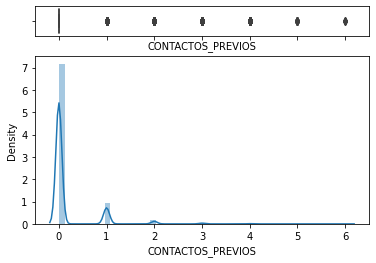

In [44]:
plot_dist(df['CONTACTOS_PREVIOS'])

<AxesSubplot:xlabel='ACEPTACION', ylabel='count'>

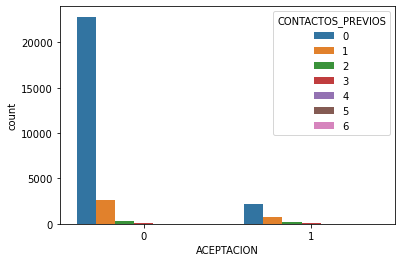

In [45]:
sns.countplot(x=df.ACEPTACION, hue=df.CONTACTOS_PREVIOS)

<AxesSubplot:xlabel='CONTACTOS_PREVIOS', ylabel='count'>

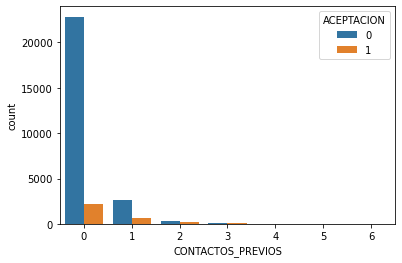

In [46]:
sns.countplot(x=df.CONTACTOS_PREVIOS, hue=df.ACEPTACION)

#### RESULT_PREVIO

In [47]:
df.RESULT_PREVIO.value_counts()

nonexistent    25024
failure         3099
success          975
Name: RESULT_PREVIO, dtype: int64

<AxesSubplot:xlabel='RESULT_PREVIO', ylabel='count'>

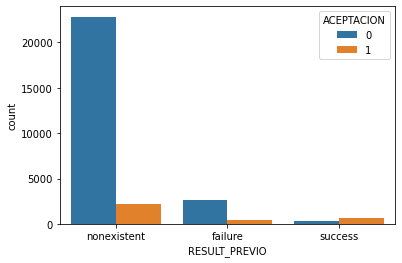

In [48]:
sns.countplot(x=df.RESULT_PREVIO, hue=df.ACEPTACION)

In [49]:
df.groupby('RESULT_PREVIO').ACEPTACION.mean().to_dict()

{'failure': 0.13972249112616975,
 'nonexistent': 0.08767583120204604,
 'success': 0.6523076923076923}

In [50]:
df['RESULT_PREVIO'] = df['RESULT_PREVIO'].replace({'failure':2,'nonexistent': 1,'success':3})

#### TASA_VAR_EMP

In [51]:
df.TASA_VAR_EMP.value_counts()

 1.4    11114
-1.8     6648
 1.1     5617
-0.1     2722
-2.9     1169
-3.4      738
-1.7      522
-1.1      441
-3.0      117
-0.2       10
Name: TASA_VAR_EMP, dtype: int64

#### IPC 

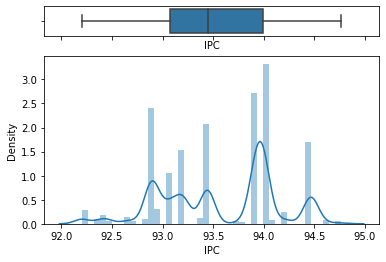

In [52]:
plot_dist(df['IPC'])

#### ICC 

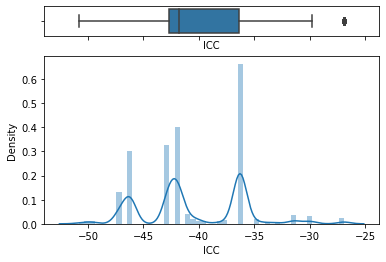

In [53]:
plot_dist(df['ICC'])

#### INGRESO 

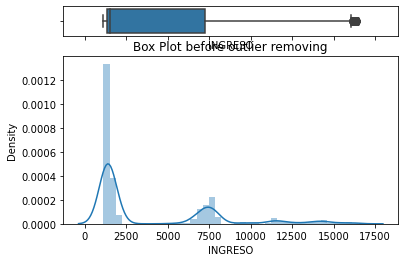

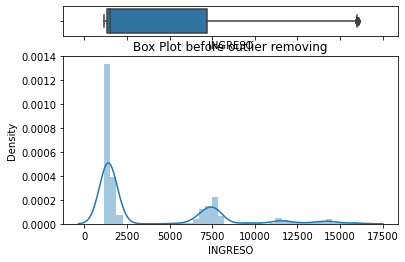

In [54]:
for i in ['INGRESO']:
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

# assigning a graph to each ax
    sns.boxplot(x =df[i], ax=ax_box)
    sns.distplot(df[i], ax=ax_hist)
    plt.title("Box Plot before outlier removing")
    plt.show()
    def drop_outliers(df, field_name):
        iqr = 1.5 * (np.percentile(df[field_name], 75) - np.percentile(df[field_name], 25))
        df.drop(df[df[field_name] > (iqr + np.percentile(df[field_name], 75))].index, inplace=True)
        df.drop(df[df[field_name] < (np.percentile(df[field_name], 25) - iqr)].index, inplace=True)
    drop_outliers(df, i)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

# assigning a graph to each ax
    sns.boxplot(x =df[i], ax=ax_box)
    sns.distplot(df[i], ax=ax_hist)
    plt.title("Box Plot before outlier removing")
    plt.show()

#### MONTO_DEUDA 

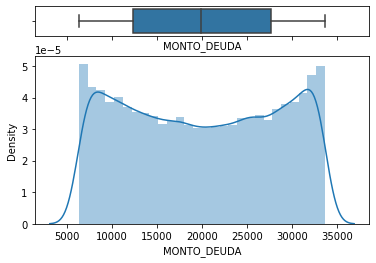

In [55]:
plot_dist(df['MONTO_DEUDA'])

#### MONTO_TRANSAC 

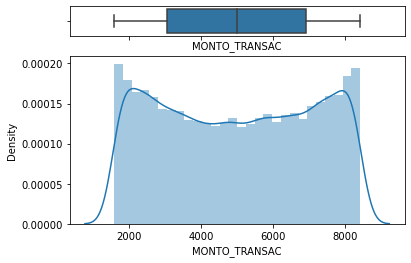

In [56]:
plot_dist(df['MONTO_TRANSAC'])

pd.set_option('display.max_rows', 15)

In [57]:
df.head()

,ID,EDAD,TRABAJO,EDUCACION,VIVIENDA,PRESTAMO,TIPO_CONTACTO,MES,CAMPANA,NRO_DIAS_CONTACTO,...,RESULT_PREVIO,TASA_VAR_EMP,IPC,ICC,INGRESO,MONTO_DEUDA,MONTO_TRANSAC,ACEPTACION,married,single
0,24004,27,28525,4,no,no,0,8,1,999,...,1,-0.1,93.798,-40.4,1285.0,24260.77053,5242.101608,0,0,1
1,24003,43,28525,3,no,no,0,8,1,999,...,1,-0.1,93.798,-40.4,1287.0,28980.09457,5538.942316,0,0,1
2,23998,44,28525,2,yes,no,0,8,1,999,...,1,-0.1,93.798,-40.4,1153.0,10937.49426,7630.664800,0,1,0
3,24005,46,28525,2,yes,no,0,8,1,999,...,1,-0.1,93.798,-40.4,1125.0,29232.60368,7008.855259,0,0,0
4,23999,42,28525,2,yes,yes,0,8,1,999,...,1,-0.1,93.798,-40.4,1443.0,32636.30279,3012.416629,1,1,0


In [61]:
#drop id
df.drop(columns='ID', axis=1, inplace=True)

In [62]:
df.shape

(27947, 20)

In [68]:
df.MES.value_counts().sort_index(ascending=True).to_frame()

,MES
3,272
4,1834
5,9775
6,3516
7,280
8,390
9,4813
10,4106
11,2867
12,94


### Modeling

In [96]:
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score,accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import shap

- separamos la data en cortes por meses usando la variable MES, formanco el train, test y out of time para tener mejor validacion

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Cargar el dataset
df = pd.read_csv('mi_dataset.csv')

# Dividir el dataset en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(df.drop('aceptacion', axis=1), df['aceptacion'], 
                                                    test_size=0.3, stratify=df['aceptacion'], 
                                                    random_state=42)

# Dividir el conjunto de prueba en conjunto de prueba y fuera de tiempo
X_test, X_oot, y_test, y_oot = train_test_split(X_test, y_test, test_size=0.5, 
                                                stratify=y_test, random_state=42)


In [110]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['ACEPTACION','MES'], axis=1)
y = df['ACEPTACION']


train = df[df['MES'].isin([3,4,5,6,7,8])]
test = df[df['MES'].isin([9,10])]
out = df[df['MES'].isin([11,12])]


X_train = train.drop(columns=['ACEPTACION','MES'], axis=1)
y_train = train['ACEPTACION']

X_test = test.drop(columns=['ACEPTACION','MES'], axis=1)
y_test = test['ACEPTACION']

X_oot = out.drop(columns=['ACEPTACION','MES'], axis=1)
y_oot = out['ACEPTACION']

df.shape[0]
print(f"Población en el train:{round(train.shape[0] /df.shape[0]*100,2) }",)
print(f"Población en el train:{round(test.shape[0] /df.shape[0]*100,2) }",)
print(f"Población en el train:{round(out.shape[0] /df.shape[0]*100,2) }",)

Población en el train:57.49
Población en el train:31.91
Población en el train:10.6


In [99]:
import xgboost as xgb

In [ ]:
dtrain = xgb.DMatrix(data=df_train2, label=y_train)
dval = xgb.DMatrix(data=df_oot2 , label=y_oot)

In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
#metrics
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,make_scorer
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score,recall_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [111]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score

# Cargar el dataset


# Definir modelo base
model = xgb.XGBClassifier(random_state=42)

# Definir parámetros a ajustar en la búsqueda de grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 500, 1000]
}

# Realizar búsqueda de grid con validación cruzada (5 folds)
grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=5)

# Entrenar el modelo con el conjunto de datos completo (sin split train/test)
grid_search.fit(X, y)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros encontrados:", grid_search.best_params_)

# Evaluar el rendimiento del modelo con validación cruzada (10 folds)
scores = cross_val_score(grid_search.best_estimator_, X, y, scoring='roc_auc', cv=10)

# Calcular el promedio y la desviación estándar del AUC-ROC en las 10 folds
print("AUC-ROC promedio con validación cruzada (10 folds): {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

# Evaluar el rendimiento del modelo en el conjunto de prueba para controlar el riesgo de sobreajuste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Entrenar el modelo con los mejores parámetros encontrados en el conjunto de entrenamiento
best_model = xgb.XGBClassifier(random_state=42, **grid_search.best_params_)
best_model.fit(X_train, y_train)

# Calcular el AUC-ROC en el conjunto de entrenamiento y el conjunto de prueba
train_preds = best_model.predict_proba(X_train)[:, 1]
test_preds = best_model.predict_proba(X_test)[:, 1]
train_auc = roc_auc_score(y_train, train_preds)
test_auc = roc_auc_score(y_test, test_preds)

print("AUC-ROC en conjunto de entrenamiento: {:.4f}".format(train_auc))
print("AUC-ROC en conjunto de prueba: {:.4f}".format(test_auc))


[05:00:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:00:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:00:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:00:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [117]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer

# Define la métrica Gini como una función de pérdida personalizada
def gini_loss(preds, dtrain):
    labels = dtrain.get_label()
    gini = 2 * roc_auc_score(labels, preds) - 1
    return 'gini', gini


X_train, X_test, y_train, y_test = train_test_split(df.drop('ACEPTACION', axis=1), df['ACEPTACION'], 
                                                    test_size=0.4, stratify=df['ACEPTACION'], 
                                                    random_state=42)

# Dividir el conjunto de prueba en conjunto de prueba y fuera de tiempo
X_test, X_oot, y_test, y_oot = train_test_split(X_test, y_test, test_size=0.5, 
                                                stratify=y_test, random_state=42)





# Define los parámetros a optimizar
params = {
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5, 7,10],
    'alpha' : [1,10,100],
    'gamma':[1,2,3,4,5],
    'n_estimators': [100, 200, 500],
    'eta':[0.01,0.05,0.1]
}

# Crea el clasificador XGBoost y el objeto scorer para la métrica Gini
clf = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
scorer = make_scorer(gini_loss, greater_is_better=True)

# Realiza la búsqueda de parámetros utilizando validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(clf, param_grid=params, cv=cv, scoring=scorer, verbose=1)
grid_search.fit(X_train, y_train)

# Evalúa el modelo con los datos de prueba y calcula la métrica de Gini
y_pred_proba_test = grid_search.predict_proba(X_test)[:, 1]
y_pred_proba_oot = grid_search.predict_proba(X_oot)[:, 1]

gini_test = 2 * roc_auc_score(y_test, y_pred_proba_test) - 1
gini_oot = 2 * roc_auc_score(y_oot, y_pred_proba_oot) - 1


print("Métrica de Gini en datos de prueba:", gini_test)
print("Métrica de Gini en datos de prueba:", gini_oot)



# Imprime los mejores parámetros encontrados y la métrica de Gini correspondiente
print("Mejores parámetros:", grid_search.best_params_)
print("Métrica de Gini en validación cruzada:", grid_search.best_score_)


Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
[05:26:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:26:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:26:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:2